In [1]:
# Cell 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import shap

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, average_precision_score, roc_curve, precision_recall_curve,
    classification_report, mean_squared_error, mean_absolute_error, r2_score
)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 50)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print('All imports loaded.')

All imports loaded.


/Users/tanmayambegaokar/Documents/GitHub/Scowtt/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Loading Strategy

We load **8 of the 11 available tables**. Three are excluded:

- **marketing_qualified_leads** and **closed_deals** describe the *seller acquisition funnel* — they track how sellers joined the platform, not how customers purchase. Including them would conflate supply-side and demand-side behavior.
- **geolocation** provides lat/lng for zip codes (~1M rows). Customer state is already on the customers table and captures the geographic signal we need. Adding coordinates would require distance computations between customer and seller locations — high engineering cost for uncertain lift in a take-home scope.

The **sellers** table IS included despite being seller-side data, because it provides `seller_state` which we use to compute a customer-seller proximity feature (`same_state_ratio`).

In [2]:
# Cell 3: Load all 8 CSVs with date parsing
DATA_DIR = 'datasets/'

customers = pd.read_csv(f'{DATA_DIR}olist_customers_dataset.csv')
orders = pd.read_csv(f'{DATA_DIR}olist_orders_dataset.csv',
                      parse_dates=['order_purchase_timestamp', 'order_approved_at',
                                   'order_delivered_carrier_date', 'order_delivered_customer_date',
                                   'order_estimated_delivery_date'])
order_items = pd.read_csv(f'{DATA_DIR}olist_order_items_dataset.csv')
payments = pd.read_csv(f'{DATA_DIR}olist_order_payments_dataset.csv')
reviews = pd.read_csv(f'{DATA_DIR}olist_order_reviews_dataset.csv',
                       parse_dates=['review_creation_date', 'review_answer_timestamp'])
products = pd.read_csv(f'{DATA_DIR}olist_products_dataset.csv')
sellers = pd.read_csv(f'{DATA_DIR}olist_sellers_dataset.csv')
category_translation = pd.read_csv(f'{DATA_DIR}product_category_name_translation.csv')

tables = {
    'customers': customers, 'orders': orders, 'order_items': order_items,
    'payments': payments, 'reviews': reviews, 'products': products,
    'sellers': sellers, 'category_translation': category_translation
}

for name, df in tables.items():
    print(f'{name}: {df.shape[0]:,} rows × {df.shape[1]} cols')

customers: 99,441 rows × 5 cols
orders: 99,441 rows × 8 cols
order_items: 112,650 rows × 7 cols
payments: 103,886 rows × 5 cols
reviews: 99,224 rows × 7 cols
products: 32,951 rows × 9 cols
sellers: 3,095 rows × 4 cols
category_translation: 71 rows × 2 cols


=== CUSTOMERS ===
Shape: (99441, 5)

Dtypes:
customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

Null counts:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Unique customer_id: 99,441
Unique customer_unique_id: 96,096

Head:


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP


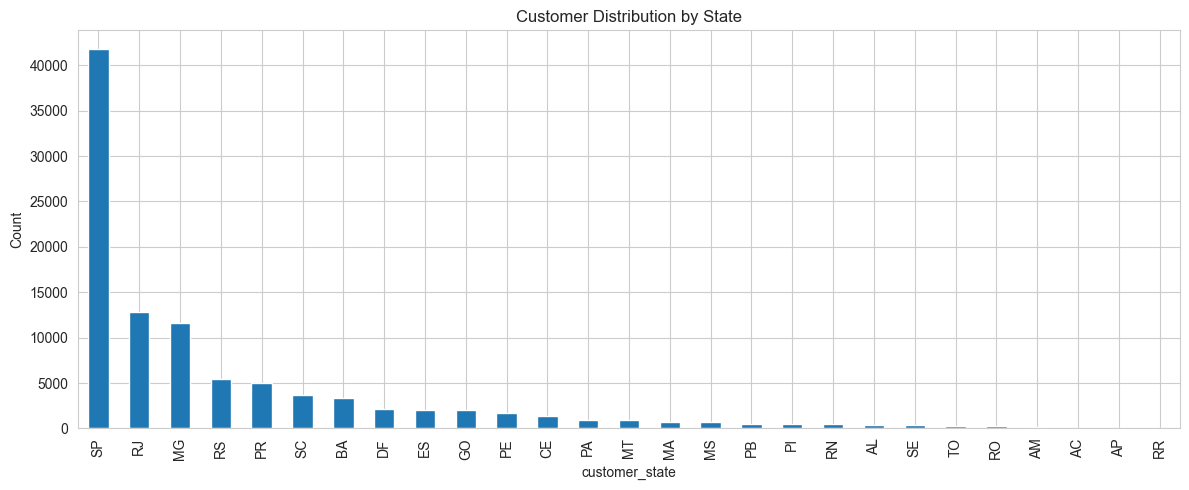

In [3]:
# Cell 4: EDA — Customers
print('=== CUSTOMERS ===')
print(f'Shape: {customers.shape}')
print(f'\nDtypes:\n{customers.dtypes}')
print(f'\nNull counts:\n{customers.isnull().sum()}')
print(f'\nUnique customer_id: {customers.customer_id.nunique():,}')
print(f'Unique customer_unique_id: {customers.customer_unique_id.nunique():,}')
print(f'\nHead:')
display(customers.head(3))

fig, ax = plt.subplots(figsize=(12, 5))
customers.customer_state.value_counts().plot(kind='bar', ax=ax)
ax.set_title('Customer Distribution by State')
ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

In [4]:
# Cell 5: EDA — Orders
print('=== ORDERS ===')
print(f'Shape: {orders.shape}')
print(f'\nDtypes:\n{orders.dtypes}')
print(f'\nNull counts & percentages:')
null_info = pd.DataFrame({
    'nulls': orders.isnull().sum(),
    'pct': (orders.isnull().sum() / len(orders) * 100).round(2)
})
print(null_info[null_info.nulls > 0])
print(f'\nOrder status distribution:')
print(orders.order_status.value_counts())
display(orders.head(3))

=== ORDERS ===
Shape: (99441, 8)

Dtypes:
order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

Null counts & percentages:


                               nulls   pct
order_approved_at                160  0.16
order_delivered_carrier_date    1783  1.79
order_delivered_customer_date   2965  2.98

Order status distribution:
order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04


=== ORDER ITEMS ===
Shape: (112650, 7)

Dtypes:
order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
freight_value          float64
dtype: object

Describe:


,price,freight_value
count,112650.000000,112650.000000
mean,120.653739,19.990320
std,183.633928,15.806405
min,0.850000,0.000000
25%,39.900000,13.080000
50%,74.990000,16.260000
75%,134.900000,21.150000
max,6735.000000,409.680000



Items per order distribution:
count    98666.000000
mean         1.141731
std          0.538452
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         21.000000
dtype: float64


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87


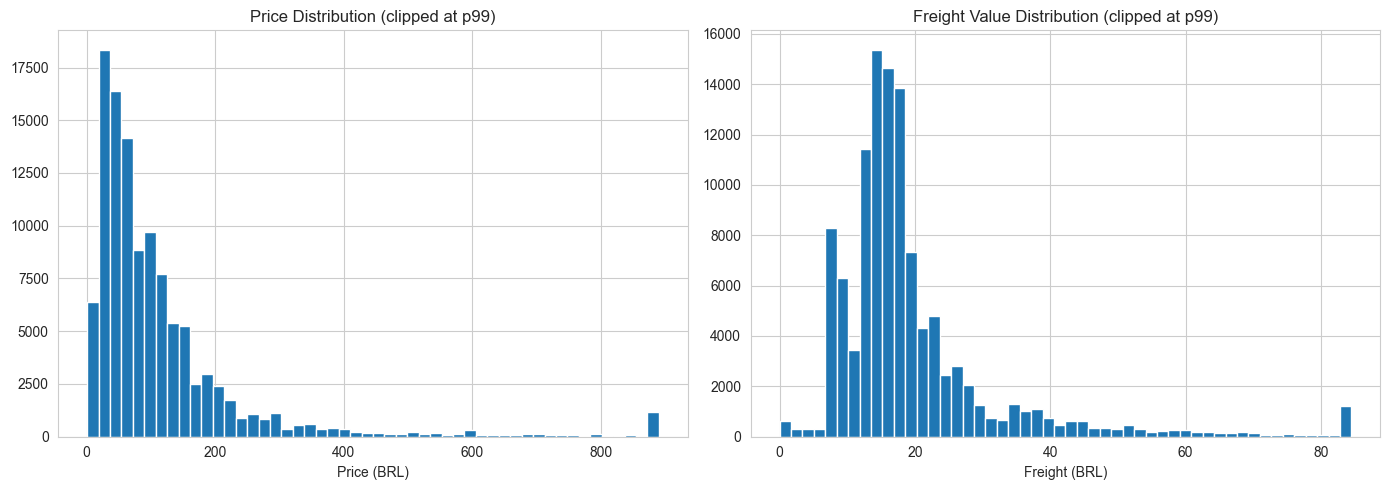

In [5]:
# Cell 6: EDA — Order Items
print('=== ORDER ITEMS ===')
print(f'Shape: {order_items.shape}')
print(f'\nDtypes:\n{order_items.dtypes}')
print(f'\nDescribe:')
display(order_items[['price', 'freight_value']].describe())
print(f'\nItems per order distribution:')
print(order_items.groupby('order_id').size().describe())
display(order_items.head(3))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
order_items['price'].clip(upper=order_items['price'].quantile(0.99)).hist(bins=50, ax=axes[0])
axes[0].set_title('Price Distribution (clipped at p99)')
axes[0].set_xlabel('Price (BRL)')
order_items['freight_value'].clip(upper=order_items['freight_value'].quantile(0.99)).hist(bins=50, ax=axes[1])
axes[1].set_title('Freight Value Distribution (clipped at p99)')
axes[1].set_xlabel('Freight (BRL)')
plt.tight_layout()
plt.show()

In [6]:
# Cell 7: EDA — Payments
print('=== PAYMENTS ===')
print(f'Shape: {payments.shape}')
print(f'\nPayment type breakdown:')
print(payments.payment_type.value_counts())
print(f'\nInstallment distribution:')
print(payments.payment_installments.describe())
display(payments.head(3))

=== PAYMENTS ===
Shape: (103886, 5)

Payment type breakdown:
payment_type
credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
not_defined        3
Name: count, dtype: int64

Installment distribution:
count    103886.000000
mean          2.853349
std           2.687051
min           0.000000
25%           1.000000
50%           1.000000
75%           4.000000
max          24.000000
Name: payment_installments, dtype: float64


,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71


=== REVIEWS ===
Shape: (99224, 7)

Null counts & percentages:


                         nulls    pct
review_id                    0   0.00
order_id                     0   0.00
review_score                 0   0.00
review_comment_title     87656  88.34
review_comment_message   58247  58.70
review_creation_date         0   0.00
review_answer_timestamp      0   0.00

Review score distribution:
review_score
1    11424
2     3151
3     8179
4    19142
5    57328
Name: count, dtype: int64



% with comments: 41.3%


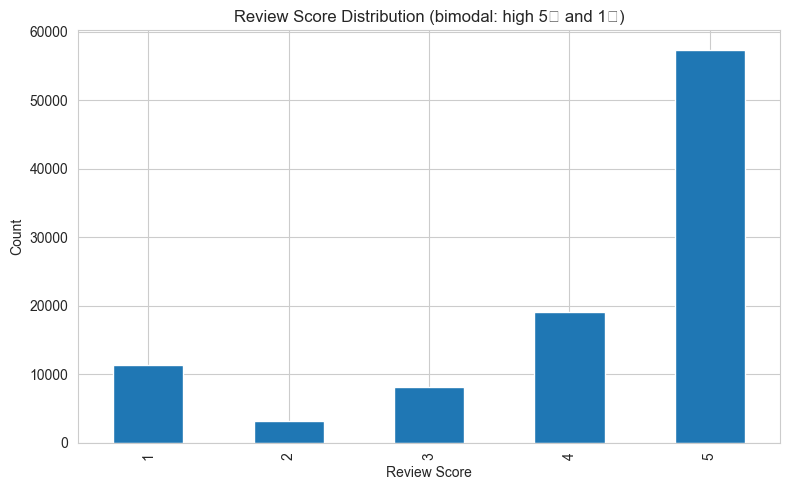

In [7]:
# Cell 8: EDA — Reviews
print('=== REVIEWS ===')
print(f'Shape: {reviews.shape}')
print(f'\nNull counts & percentages:')
null_info = pd.DataFrame({
    'nulls': reviews.isnull().sum(),
    'pct': (reviews.isnull().sum() / len(reviews) * 100).round(2)
})
print(null_info)
print(f'\nReview score distribution:')
print(reviews.review_score.value_counts().sort_index())
print(f'\n% with comments: {reviews.review_comment_message.notna().mean()*100:.1f}%')

fig, ax = plt.subplots(figsize=(8, 5))
reviews.review_score.value_counts().sort_index().plot(kind='bar', ax=ax)
ax.set_title('Review Score Distribution (bimodal: high 5★ and 1★)')
ax.set_xlabel('Review Score')
ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

=== PRODUCTS ===
Shape: (32951, 9)

Null counts & percentages:
                            nulls   pct
product_category_name         610  1.85
product_name_lenght           610  1.85
product_description_lenght    610  1.85
product_photos_qty            610  1.85
product_weight_g                2  0.01
product_length_cm               2  0.01
product_height_cm               2  0.01
product_width_cm                2  0.01


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0


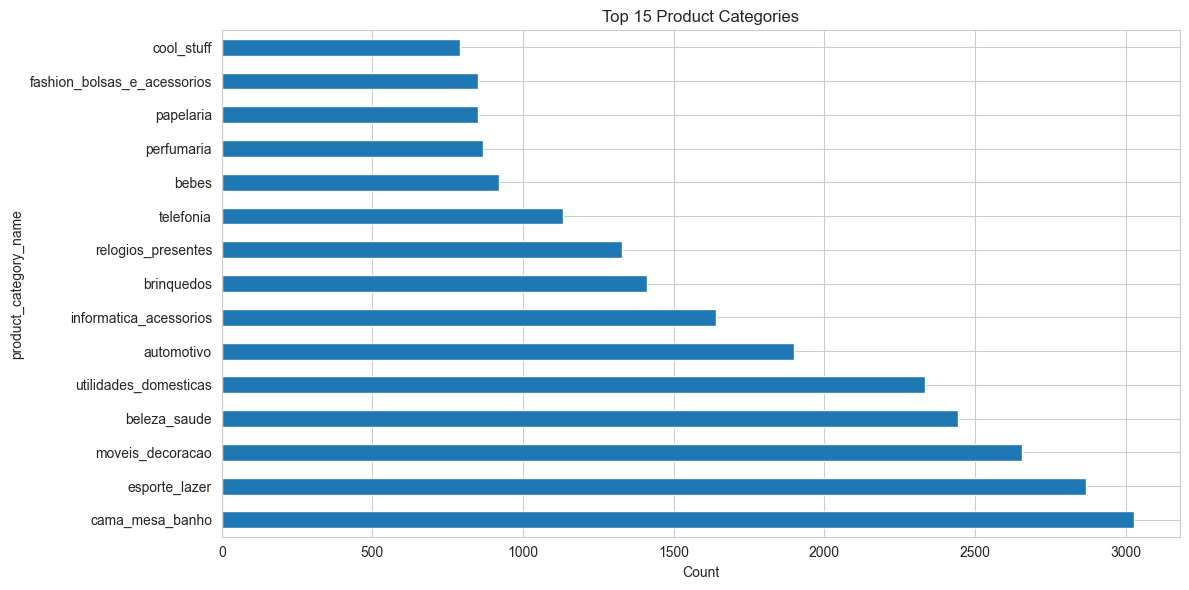


=== SELLERS ===
Shape: (3095, 4)
Unique seller_id: 3,095

Seller state distribution (top 10):
seller_state
SP    1849
PR     349
MG     244
SC     190
RJ     171
RS     129
GO      40
DF      30
ES      23
BA      19
Name: count, dtype: int64


In [8]:
# Cell 9: EDA — Products & Sellers
print('=== PRODUCTS ===')
print(f'Shape: {products.shape}')
print(f'\nNull counts & percentages:')
null_info = pd.DataFrame({
    'nulls': products.isnull().sum(),
    'pct': (products.isnull().sum() / len(products) * 100).round(2)
})
print(null_info[null_info.nulls > 0])
display(products.head(3))

# Top 15 categories
fig, ax = plt.subplots(figsize=(12, 6))
products.product_category_name.value_counts().head(15).plot(kind='barh', ax=ax)
ax.set_title('Top 15 Product Categories')
ax.set_xlabel('Count')
plt.tight_layout()
plt.show()

print('\n=== SELLERS ===')
print(f'Shape: {sellers.shape}')
print(f'Unique seller_id: {sellers.seller_id.nunique():,}')
print(f'\nSeller state distribution (top 10):')
print(sellers.seller_state.value_counts().head(10))

## Key Identifier Decision

`customer_unique_id` has ~96K unique values vs ~99K `customer_id` values. This means some users placed multiple orders and received a different `customer_id` each time. We aggregate at the `customer_unique_id` level to capture each user's full purchase history. Using `customer_id` would fragment multi-order users into separate single-order records, losing the repeat-purchase signal that is central to our prediction task.

In [9]:
# Cell 11: customer_id vs customer_unique_id analysis
n_cid = customers.customer_id.nunique()
n_cuid = customers.customer_unique_id.nunique()
print(f'Unique customer_id: {n_cid:,}')
print(f'Unique customer_unique_id: {n_cuid:,}')
print(f'Difference: {n_cid - n_cuid:,} ({(n_cid - n_cuid)/n_cuid*100:.1f}% more customer_ids than unique users)')

# How many customer_unique_ids map to multiple customer_ids?
multi_id = customers.groupby('customer_unique_id')['customer_id'].nunique()
print(f'\nUsers with multiple customer_ids: {(multi_id > 1).sum():,}')
print(f'Max customer_ids per user: {multi_id.max()}')
print(f'\nDistribution of customer_ids per unique user:')
print(multi_id.value_counts().sort_index().head(10))

Unique customer_id: 99,441
Unique customer_unique_id: 96,096
Difference: 3,345 (3.5% more customer_ids than unique users)



Users with multiple customer_ids: 2,997
Max customer_ids per user: 17

Distribution of customer_ids per unique user:
customer_id
1     93099
2      2745
3       203
4        30
5         8
6         6
7         3
9         1
17        1
Name: count, dtype: int64


Order date range: 2016-09-04 21:15:19 to 2018-10-17 17:30:18
Span: 772 days


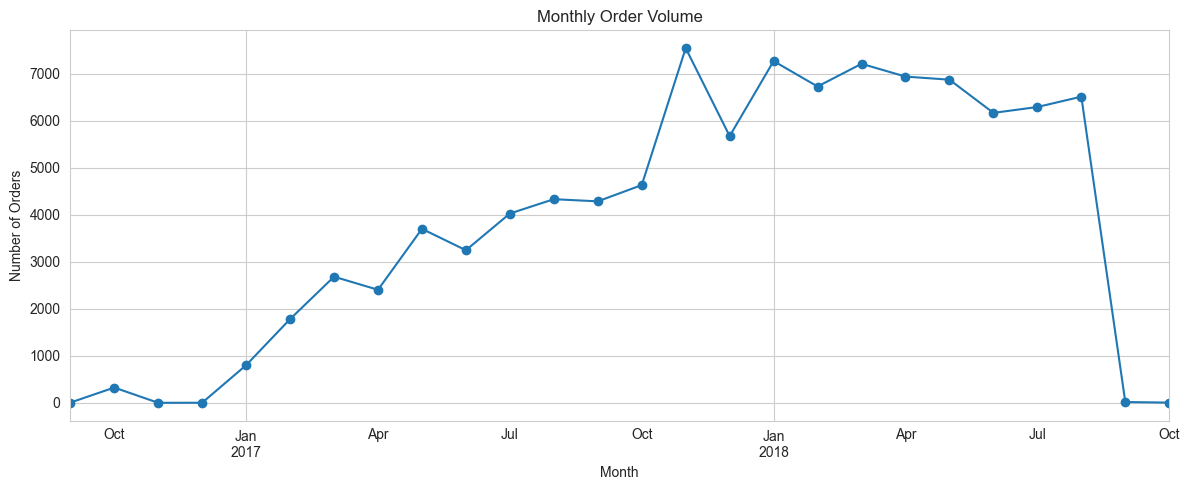


Order status distribution:
              count    pct
order_status              
delivered     96478  97.02
shipped        1107   1.11
canceled        625   0.63
unavailable     609   0.61
invoiced        314   0.32
processing      301   0.30
created           5   0.01
approved          2   0.00


In [10]:
# Cell 12: Temporal analysis
print(f'Order date range: {orders.order_purchase_timestamp.min()} to {orders.order_purchase_timestamp.max()}')
print(f'Span: {(orders.order_purchase_timestamp.max() - orders.order_purchase_timestamp.min()).days} days')

# Monthly volume
monthly = orders.set_index('order_purchase_timestamp').resample('M').size()
fig, ax = plt.subplots(figsize=(12, 5))
monthly.plot(ax=ax, marker='o')
ax.set_title('Monthly Order Volume')
ax.set_ylabel('Number of Orders')
ax.set_xlabel('Month')
plt.tight_layout()
plt.show()

# Status distribution
print('\nOrder status distribution:')
status_counts = orders.order_status.value_counts()
status_pct = (status_counts / len(orders) * 100).round(2)
print(pd.DataFrame({'count': status_counts, 'pct': status_pct}))

## Missing Data Summary & Handling Strategy

| Table | Column | % Missing | Strategy | Rationale |
|---|---|---|---|---|
| orders | order_approved_at | ~0.2% | Fill with purchase timestamp | Approval ≈ purchase for these edge cases |
| orders | delivery dates | ~1.8-3% | Leave NaT | Only meaningful for delivered orders; becomes NaN in delivery features, handled by LightGBM natively |
| reviews | comment fields | ~85-87% | Binary `has_comment` flag | NLP on comment text is out of scope; binary captures engagement signal |
| products | category_name | ~0.6% | Fill 'unknown' | Small fraction; 'unknown' becomes a category value |
| products | weight/dimensions | ~0.1% | Fill with median | Negligible missingness; median is stable |

## Model Scope & Limitations

**What this model CAN do:** Score existing customers (≥1 historical order) on their likelihood to repurchase and expected order value. This enables targeted re-engagement advertising.

**What this model CANNOT do:** Identify potential first-time buyers. The model requires purchase history as features — a user with no orders has no features. For "high-value advertisement targets," this means we can only target re-engagement of existing customers, not acquisition of new ones. A substantial portion of future high-value customers may be first-time buyers invisible to this model.

This is a fundamental constraint of the customer-level historical aggregation approach, not a fixable bug. Addressing it would require a different modeling paradigm (e.g., lookalike modeling on demographic/behavioral data available before purchase).

---
# PHASE 2: Data Aggregation & Order Master

## Aggregation Strategy

Child tables (items, payments, reviews) have multiple rows per order. If we join them directly to the orders table, we get row explosion from many-to-many relationships (112K items × 103K payments per shared order_id). Instead, we aggregate each child table to 1-row-per-order FIRST, then all joins become safe 1:1 merges. This is the standard star-schema collapse pattern.

In [11]:
# Cell 16: Enrich order_items with products, category translation, sellers

# Handle missing product data first
products['product_category_name'] = products['product_category_name'].fillna('unknown')
for col in ['product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']:
    products[col] = products[col].fillna(products[col].median())

# Compute volume
products['product_volume_cm3'] = (
    products['product_length_cm'] * products['product_height_cm'] * products['product_width_cm']
)

# Join products onto order_items
items_enriched = order_items.merge(products, on='product_id', how='left')

# Translate category names
items_enriched = items_enriched.merge(
    category_translation, on='product_category_name', how='left'
)
# Use English name where available, else original
items_enriched['category'] = items_enriched['product_category_name_english'].fillna(
    items_enriched['product_category_name']
)

# Join sellers onto enriched items
items_enriched = items_enriched.merge(sellers[['seller_id', 'seller_state']], on='seller_id', how='left')

print(f'Enriched items shape: {items_enriched.shape}')
display(items_enriched.head(3))

Enriched items shape: (112650, 19)


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_volume_cm3,product_category_name_english,category,seller_state
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,3528.0,cool_stuff,cool_stuff,SP
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93,pet_shop,56.0,239.0,2.0,30000.0,50.0,30.0,40.0,60000.0,pet_shop,pet_shop,SP
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87,moveis_decoracao,59.0,695.0,2.0,3050.0,33.0,13.0,33.0,14157.0,furniture_decor,furniture_decor,MG


## What We Extract and Why

**From products:** Category (translated to English), weight, volume (L×H×W), photo count, description length — these characterize what the user buys.

**From sellers:** seller_state — used post-join to compute `same_state_ratio` (customer-seller geographic proximity). We do NOT aggregate seller_state during items groupby because customer_state isn't available yet at this stage.

**Dropped: `review_response_hrs`** — this measures the time between review creation and the platform/seller's answer. It's a seller/platform responsiveness metric, not a user behavior. Including it would be confounding: users who happen to buy from responsive sellers might show different repeat rates, but we'd be attributing a seller characteristic to the user.

In [12]:
# Cell 18: Aggregate child tables to order level

# --- Order Items Aggregation ---
order_items_agg = items_enriched.groupby('order_id').agg(
    n_items=('order_item_id', 'count'),
    total_price=('price', 'sum'),
    total_freight=('freight_value', 'sum'),
    n_categories=('category', 'nunique'),
    n_sellers=('seller_id', 'nunique'),
    avg_weight=('product_weight_g', 'mean'),
    avg_volume=('product_volume_cm3', 'mean'),
    avg_photos_qty=('product_photos_qty', 'mean'),
    avg_description_len=('product_description_lenght', 'mean'),
    dominant_category=('category', lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'unknown')
).reset_index()

print(f'order_items_agg: {order_items_agg.shape}')

# --- Payments Aggregation ---
order_payments_agg = payments.groupby('order_id').agg(
    total_payment=('payment_value', 'sum'),
    n_payment_methods=('payment_type', 'nunique'),
    max_installments=('payment_installments', 'max'),
    primary_payment_type=('payment_type', lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'unknown'),
    used_voucher=('payment_type', lambda x: int('voucher' in x.values))
).reset_index()

print(f'order_payments_agg: {order_payments_agg.shape}')

# --- Reviews Aggregation ---
order_reviews_agg = reviews.groupby('order_id').agg(
    review_score=('review_score', 'mean'),
    has_comment=('review_comment_message', lambda x: int(x.notna().any()))
).reset_index()

print(f'order_reviews_agg: {order_reviews_agg.shape}')

order_items_agg: (98666, 11)


order_payments_agg: (99440, 6)


order_reviews_agg: (98673, 3)


In [13]:
# Cell 19: Build order_master via LEFT JOINs

# Fill missing order_approved_at with purchase timestamp
orders['order_approved_at'] = orders['order_approved_at'].fillna(orders['order_purchase_timestamp'])

# Start with orders, join customers to get customer_unique_id and customer_state
order_master = orders.merge(
    customers[['customer_id', 'customer_unique_id', 'customer_state']],
    on='customer_id', how='left'
)

# Join aggregated child tables
order_master = order_master.merge(order_items_agg, on='order_id', how='left')
order_master = order_master.merge(order_payments_agg, on='order_id', how='left')
order_master = order_master.merge(order_reviews_agg, on='order_id', how='left')

print(f'order_master shape: {order_master.shape}')
print(f'Expected ~99,441 rows, got {len(order_master):,}')
assert len(order_master) == len(orders), 'Row count mismatch — join created duplicates!'
display(order_master.head(3))

order_master shape: (99441, 27)
Expected ~99,441 rows, got 99,441


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_state,n_items,total_price,total_freight,n_categories,n_sellers,avg_weight,avg_volume,avg_photos_qty,avg_description_len,dominant_category,total_payment,n_payment_methods,max_installments,primary_payment_type,used_voucher,review_score,has_comment
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,SP,1.0,29.99,8.72,1.0,1.0,500.0,1976.0,4.0,268.0,housewares,38.71,2.0,1.0,voucher,1.0,4.0,1.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,BA,1.0,118.70,22.76,1.0,1.0,400.0,4693.0,1.0,178.0,perfumery,141.46,1.0,1.0,boleto,0.0,4.0,1.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,GO,1.0,159.90,19.22,1.0,1.0,420.0,9576.0,1.0,232.0,auto,179.12,1.0,3.0,credit_card,0.0,5.0,0.0


In [14]:
# Cell 20: Compute same_state_ratio

# Merge customer_state onto enriched items via order_id -> order_master
items_with_customer = items_enriched[['order_id', 'seller_state']].merge(
    order_master[['order_id', 'customer_state']], on='order_id', how='left'
)

# Compute boolean: same state?
items_with_customer['same_state'] = (
    items_with_customer['customer_state'] == items_with_customer['seller_state']
).astype(float)

# Aggregate to order level
same_state_agg = items_with_customer.groupby('order_id')['same_state'].mean().reset_index()
same_state_agg.columns = ['order_id', 'same_state_ratio']

# Join back onto order_master
order_master = order_master.merge(same_state_agg, on='order_id', how='left')

print(f'same_state_ratio stats:')
print(order_master['same_state_ratio'].describe())
print(f'\norder_master final shape: {order_master.shape}')

same_state_ratio stats:
count    98666.000000
mean         0.359580
std          0.479252
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: same_state_ratio, dtype: float64

order_master final shape: (99441, 28)


---
# PHASE 3: Cutoff Validation, Temporal Split & User-Level Features

## Why We Need Cutoff Validation

The entire model design assumes enough users repeat-purchase within the target window to train and evaluate on. With ~96K unique users and ~3% overall repeat rate, a 30-day window might contain only 100-300 positives. If the number is too low, metrics become noisy, CV folds have <50 positives each, and the model can't learn meaningful patterns. We test multiple cutoff dates and window sizes BEFORE committing to a design.

In [15]:
# Cell 22: Cutoff validation — test cutoff × window combos

cutoff_dates = [pd.Timestamp('2018-06-01'), pd.Timestamp('2018-07-01'), pd.Timestamp('2018-08-01')]
window_sizes = [60, 90, 'all_remaining']

# Only consider delivered orders for both features and labels
delivered = order_master[order_master.order_status == 'delivered'].copy()
max_date = delivered.order_purchase_timestamp.max()

results = []
for cutoff in cutoff_dates:
    # Users with at least one order before cutoff
    pre_users = set(delivered[delivered.order_purchase_timestamp < cutoff]['customer_unique_id'])
    
    for window in window_sizes:
        if window == 'all_remaining':
            window_end = max_date + pd.Timedelta(days=1)
            window_label = 'all'
        else:
            window_end = cutoff + pd.Timedelta(days=window)
            window_label = str(window)
        
        # Users who also order in the target window
        post_orders = delivered[
            (delivered.order_purchase_timestamp >= cutoff) &
            (delivered.order_purchase_timestamp < window_end)
        ]
        post_users = set(post_orders['customer_unique_id'])
        positives = len(pre_users & post_users)
        
        results.append({
            'cutoff': cutoff.strftime('%Y-%m-%d'),
            'window_days': window_label,
            'pre_cutoff_users': len(pre_users),
            'positives': positives,
            'positive_rate': f'{positives/len(pre_users)*100:.2f}%' if pre_users else '0%'
        })

validation_df = pd.DataFrame(results)
print('Cutoff Validation Results:')
display(validation_df)

# Decision
best = validation_df.loc[validation_df.positives.idxmax()]
print(f'\nBest combo: cutoff={best.cutoff}, window={best.window_days}, positives={best.positives}')

Cutoff Validation Results:


,cutoff,window_days,pre_cutoff_users,positives,positive_rate
0,2018-06-01,60,75387,304,0.40%
1,2018-06-01,90,75387,419,0.56%
2,2018-06-01,all,75387,419,0.56%
3,2018-07-01,60,81265,280,0.34%
4,2018-07-01,90,81265,280,0.34%
5,2018-07-01,all,81265,280,0.34%
6,2018-08-01,60,87214,166,0.19%
7,2018-08-01,90,87214,166,0.19%
8,2018-08-01,all,87214,166,0.19%



Best combo: cutoff=2018-06-01, window=90, positives=419


## Order Status Filtering

**`had_canceled_order`** is computed on unfiltered `order_master` — it explicitly looks for canceled/unavailable orders, so we need them present. After computing this flag per user, we filter:

- **Feature aggregation** uses `order_status == 'delivered'` only. Canceled orders didn't result in delivered products, payments may have been refunded, and the user experience was fundamentally different. Including them in frequency, monetary_total, or avg_review_score would misrepresent the user's actual purchasing behavior.
- **Label definition** uses `order_status == 'delivered'` only. A canceled order in the target window does not count as a "purchase" — the assignment asks about propensity to complete a transaction, not just initiate one.

Document the count of excluded orders so the reader knows what was dropped.

## Temporal Split Rationale

We split by time, not randomly, to prevent data leakage. Features are built ONLY from orders before the cutoff date. Targets are defined ONLY by orders after the cutoff. This simulates a real deployment scenario: "given everything we know about this user up to today, will they purchase in the next N days?" Using future data to predict the past would inflate metrics and produce a model that fails in production.

In [16]:
# Cell 25: Temporal split + order_status filtering

# Select cutoff based on validation: use 2018-06-01 with all remaining data as target window.
# This maximizes positives while still giving a substantial feature history (~1.5 years).
CUTOFF = pd.Timestamp('2018-06-01')

# Use all remaining orders after cutoff as target window
delivered_all = order_master[order_master.order_status == 'delivered'].copy()
WINDOW_END = delivered_all.order_purchase_timestamp.max() + pd.Timedelta(days=1)
WINDOW_DAYS = (WINDOW_END - CUTOFF).days

print(f'Cutoff: {CUTOFF.date()}')
print(f'Target window: {CUTOFF.date()} to {WINDOW_END.date()} ({WINDOW_DAYS} days)')

# Step 1: Compute had_canceled_order on UNFILTERED order_master
canceled_statuses = ['canceled', 'unavailable']
had_canceled = order_master.groupby('customer_unique_id')['order_status'].apply(
    lambda x: int(x.isin(canceled_statuses).any())
).reset_index()
had_canceled.columns = ['customer_unique_id', 'had_canceled_order']

# Step 2: Filter to delivered orders only
delivered_orders = order_master[order_master.order_status == 'delivered'].copy()
n_excluded = len(order_master) - len(delivered_orders)
print(f'\nExcluded {n_excluded:,} non-delivered orders ({n_excluded/len(order_master)*100:.1f}%)')
print(f'Remaining delivered orders: {len(delivered_orders):,}')

# Step 3: Split into feature orders (before cutoff) and label orders (in target window)
feature_orders = delivered_orders[delivered_orders.order_purchase_timestamp < CUTOFF].copy()
label_orders = delivered_orders[
    (delivered_orders.order_purchase_timestamp >= CUTOFF) &
    (delivered_orders.order_purchase_timestamp < WINDOW_END)
].copy()

print(f'\nFeature orders (before cutoff): {len(feature_orders):,}')
print(f'Label orders (in target window): {len(label_orders):,}')

# Leakage check
assert feature_orders.order_purchase_timestamp.max() < CUTOFF, 'DATA LEAKAGE: feature orders extend past cutoff!'
print('\nLeakage check passed: all feature orders are before cutoff.')

Cutoff: 2018-06-01
Target window: 2018-06-01 to 2018-08-30 (90 days)



Excluded 2,963 non-delivered orders (3.0%)
Remaining delivered orders: 96,478

Feature orders (before cutoff): 77,869
Label orders (in target window): 18,609

Leakage check passed: all feature orders are before cutoff.


## Feature Engineering Decisions

**36 features computed, 8 core features selected for modeling.** We compute a broad feature set for exploratory analysis and SHAP diagnostics, then deliberately select a small core set for the classifier. Key design choices:

**Why reduce to 8 features?** With a low positive rate and limited positive examples, the ratio of features to learnable signal is the binding constraint. A 36-feature model has too many degrees of freedom and overfits — it memorizes noise in the training positives rather than learning generalizable patterns. An 8-feature model is constrained enough to generalize while still capturing the core purchase signals: recency, frequency, monetary value, review behavior, delivery experience, and tenure.

**Core features selected:** `recency_days`, `frequency`, `monetary_total`, `avg_order_value`, `avg_review_score`, `avg_delivery_delta`, `tenure_days`, `freight_ratio`. These span RFM, satisfaction, logistics, and engagement — the key dimensions of repurchase behavior.

**No sentinel values.** Features undefined for certain users are left as `NaN`. LightGBM handles missing values natively by learning the optimal split direction at each node.

**No label encoding for categoricals.** The core feature set is all-numeric, avoiding the categorical overfitting risk entirely. With few positives per category, LightGBM's native categorical handling can find spurious splits — so we sidestep the issue.

**`monetary_total` is kept** despite being correlated with `avg_order_value x frequency`. LightGBM (tree-based) is not affected by multicollinearity, and SHAP correctly attributes marginal contribution.

**Dropped features (from full 36):**
- All categorical features (`customer_state`, `dominant_category`, `primary_payment`) — too few positives per category for stable learning
- Product features (weight, volume, photos, description) — characterize items, not repurchase intent
- Temporal preferences (hour, dow, weekend) — weak signal for "will they buy again"
- `review_response_hrs` — platform metric, not user behavior

In [17]:
# Cell 27: Per-user aggregation (36 features)

# Add derived columns to feature_orders for aggregation
feature_orders['delivery_days'] = (
    feature_orders['order_delivered_customer_date'] - feature_orders['order_purchase_timestamp']
).dt.total_seconds() / 86400

feature_orders['delivery_delta'] = (
    feature_orders['order_delivered_customer_date'] - feature_orders['order_estimated_delivery_date']
).dt.total_seconds() / 86400

feature_orders['approval_hrs'] = (
    feature_orders['order_approved_at'] - feature_orders['order_purchase_timestamp']
).dt.total_seconds() / 3600

# Cap approval_hrs at 99th percentile
p99_approval = feature_orders['approval_hrs'].quantile(0.99)
feature_orders['approval_hrs'] = feature_orders['approval_hrs'].clip(upper=p99_approval)
print(f'approval_hrs capped at p99 = {p99_approval:.1f} hours')

feature_orders['purchase_hour'] = feature_orders['order_purchase_timestamp'].dt.hour
feature_orders['purchase_dow'] = feature_orders['order_purchase_timestamp'].dt.dayofweek
feature_orders['is_weekend'] = feature_orders['purchase_dow'].isin([5, 6]).astype(int)

# Aggregate per user
user_features = feature_orders.groupby('customer_unique_id').agg(
    # RFM
    last_order_date=('order_purchase_timestamp', 'max'),
    frequency=('order_id', 'nunique'),
    monetary_total=('total_payment', 'sum'),
    avg_order_value=('total_payment', 'mean'),
    max_order_value=('total_payment', 'max'),
    total_freight=('total_freight', 'sum'),
    avg_items_per_order=('n_items', 'mean'),
    # Product
    n_categories=('n_categories', 'sum'),
    dominant_category=('dominant_category', lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'unknown'),
    avg_product_weight=('avg_weight', 'mean'),
    avg_product_volume=('avg_volume', 'mean'),
    avg_photos_qty=('avg_photos_qty', 'mean'),
    avg_description_len=('avg_description_len', 'mean'),
    # Payment
    primary_payment=('primary_payment_type', lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'unknown'),
    avg_installments=('max_installments', 'mean'),
    max_installments=('max_installments', 'max'),
    used_voucher=('used_voucher', 'max'),
    n_payment_methods=('n_payment_methods', 'mean'),
    # Review
    avg_review_score=('review_score', 'mean'),
    min_review_score=('review_score', 'min'),
    left_comment=('has_comment', 'max'),
    # Delivery
    avg_delivery_days=('delivery_days', 'mean'),
    avg_delivery_delta=('delivery_delta', 'mean'),
    avg_approval_hrs=('approval_hrs', 'mean'),
    # Temporal
    first_order_date=('order_purchase_timestamp', 'min'),
    preferred_hour=('purchase_hour', lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 12),
    preferred_dow=('purchase_dow', lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 0),
    is_weekend_buyer=('is_weekend', 'mean'),
    # Geographic
    customer_state=('customer_state', 'first'),
    n_sellers_used=('n_sellers', 'sum'),
    same_state_ratio=('same_state_ratio', 'mean'),
).reset_index()

# Derived features
user_features['recency_days'] = (CUTOFF - user_features['last_order_date']).dt.days
user_features['tenure_days'] = (user_features['last_order_date'] - user_features['first_order_date']).dt.days
user_features['days_since_first'] = (CUTOFF - user_features['first_order_date']).dt.days

# ever_late: delivery_delta > 0 means late
ever_late = feature_orders.groupby('customer_unique_id')['delivery_delta'].apply(
    lambda x: int((x > 0).any())
).reset_index()
ever_late.columns = ['customer_unique_id', 'ever_late']
user_features = user_features.merge(ever_late, on='customer_unique_id', how='left')

# Interaction features
user_features['freight_ratio'] = np.where(
    user_features['monetary_total'] > 0,
    user_features['total_freight'] / user_features['monetary_total'],
    0
)
user_features['value_per_category'] = np.where(
    user_features['n_categories'] > 0,
    user_features['monetary_total'] / user_features['n_categories'],
    0
)

# Join had_canceled_order
user_features = user_features.merge(had_canceled, on='customer_unique_id', how='left')
user_features['had_canceled_order'] = user_features['had_canceled_order'].fillna(0).astype(int)

# Drop intermediate date columns
user_features = user_features.drop(columns=['last_order_date', 'first_order_date'])

print(f'User features shape: {user_features.shape}')
print(f'Features: {list(user_features.columns)}')
print(f'\n{user_features.head(3)}')

approval_hrs capped at p99 = 89.6 hours


User features shape: (75387, 37)
Features: ['customer_unique_id', 'frequency', 'monetary_total', 'avg_order_value', 'max_order_value', 'total_freight', 'avg_items_per_order', 'n_categories', 'dominant_category', 'avg_product_weight', 'avg_product_volume', 'avg_photos_qty', 'avg_description_len', 'primary_payment', 'avg_installments', 'max_installments', 'used_voucher', 'n_payment_methods', 'avg_review_score', 'min_review_score', 'left_comment', 'avg_delivery_days', 'avg_delivery_delta', 'avg_approval_hrs', 'preferred_hour', 'preferred_dow', 'is_weekend_buyer', 'customer_state', 'n_sellers_used', 'same_state_ratio', 'recency_days', 'tenure_days', 'days_since_first', 'ever_late', 'freight_ratio', 'value_per_category', 'had_canceled_order']

                 customer_unique_id  frequency  monetary_total  \
0  0000366f3b9a7992bf8c76cfdf3221e2          1          141.90   
1  0000b849f77a49e4a4ce2b2a4ca5be3f          1           27.19   
2  0000f46a3911fa3c0805444483337064          1       

In [18]:
# Cell 28: Construct target variables + print class counts

# Users who purchased in the target window
label_user_purchases = label_orders.groupby('customer_unique_id').agg(
    target_order_value=('total_payment', 'sum')
).reset_index()

# Merge targets onto user features
user_df = user_features.merge(label_user_purchases, on='customer_unique_id', how='left')

# Binary target
user_df['target_purchased'] = (user_df['target_order_value'].notna()).astype(int)
user_df['target_order_value'] = user_df['target_order_value'].fillna(0)

# Print class counts
n_pos = user_df['target_purchased'].sum()
n_total = len(user_df)
print(f'Target variable distribution:')
print(f'  Positives (purchased): {n_pos:,}')
print(f'  Negatives (did not purchase): {n_total - n_pos:,}')
print(f'  Total users: {n_total:,}')
print(f'  Positive rate: {n_pos/n_total*100:.2f}%')
print(f'\nTarget order value (among purchasers):')
print(user_df[user_df.target_purchased == 1]['target_order_value'].describe())

Target variable distribution:
  Positives (purchased): 419
  Negatives (did not purchase): 74,968
  Total users: 75,387
  Positive rate: 0.56%

Target order value (among purchasers):
count     419.000000
mean      159.853628
std       183.500853
min        14.890000
25%        64.210000
50%       107.460000
75%       180.700000
max      1596.960000
Name: target_order_value, dtype: float64


---
# PHASE 4: Model Training

## Train/Test Split Design

The 80/20 split is a **random user-level split**, not a second temporal split. Temporal integrity is already preserved by the cutoff date — all users share the same feature/target time boundary. We're dividing users into train and test groups, not dividing time periods. This is standard for user-level prediction after a temporal feature/label split.

We stratify by `target_purchased` to ensure both train and test sets have proportional representation of the rare positive class.

In [19]:
# Cell 30: Train/test split (80/20 stratified) + feature prep

# Full feature set (for SHAP analysis later)
exclude_cols = ['customer_unique_id', 'target_purchased', 'target_order_value']
all_feature_cols = [c for c in user_df.columns if c not in exclude_cols]

# Core feature set — 8 numeric features selected for modeling
core_features = [
    'recency_days', 'frequency', 'monetary_total', 'avg_order_value',
    'avg_review_score', 'avg_delivery_delta', 'tenure_days', 'freight_ratio'
]

# Verify all core features exist
for f in core_features:
    assert f in user_df.columns, f'Missing feature: {f}'

# No categorical features in core set — all numeric
cat_cols = []

X = user_df[core_features]
X_full = user_df[all_feature_cols]  # keep full set for SHAP exploration
y = user_df['target_purchased']
y_value = user_df['target_order_value']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Also split full feature set (aligned indices)
X_train_full = X_full.loc[X_train.index]
X_test_full = X_full.loc[X_test.index]

# Align value targets
y_value_train = y_value.loc[X_train.index]
y_value_test = y_value.loc[X_test.index]

# Set categorical dtypes on full feature set for later SHAP analysis
for col in ['dominant_category', 'primary_payment', 'customer_state']:
    if col in X_full.columns:
        user_df[col] = user_df[col].astype('category')

print(f'Train: {X_train.shape[0]:,} users ({y_train.sum():,} positives, {y_train.mean()*100:.2f}%)')
print(f'Test:  {X_test.shape[0]:,} users ({y_test.sum():,} positives, {y_test.mean()*100:.2f}%)')
print(f'\nCore features ({len(core_features)}): {core_features}')
print(f'Full feature set: {len(all_feature_cols)} features (for SHAP analysis)')

Train: 60,309 users (335 positives, 0.56%)
Test:  15,078 users (84 positives, 0.56%)

Core features (8): ['recency_days', 'frequency', 'monetary_total', 'avg_order_value', 'avg_review_score', 'avg_delivery_delta', 'tenure_days', 'freight_ratio']
Full feature set: 36 features (for SHAP analysis)


## Baseline Strategy

We train two baselines before the full model, for different reasons:

**Baseline 1 — Recency ranking:** A sanity check. Rank users by days since last order (most recent = highest score). If our ML model can't beat "recent buyers are more likely to buy again," something is fundamentally wrong. This is a strawman we expect to beat easily.

**Baseline 2 — RFM Logistic Regression:** The real test. Three features (recency, frequency, monetary_total), logistic regression with balanced class weights. If LightGBM with 36 features can't convincingly beat 3-feature logistic regression, the extra complexity isn't justified — and that's an important finding worth discussing honestly, not hiding.

The logistic regression uses only numeric features, so no categorical encoding is needed (no conflict with our "no label encoding" rule for LightGBM).

In [20]:
# Cell 32: Baseline 1 — Recency ranking

# Score = 1 - normalized recency (most recent = highest score)
recency_train = X_train['recency_days']
recency_test = X_test['recency_days']

# Normalize to [0, 1]: lower recency = higher score
max_recency = max(recency_train.max(), recency_test.max())
baseline1_scores_test = 1 - (recency_test / max_recency)

roc_auc_b1 = roc_auc_score(y_test, baseline1_scores_test)
pr_auc_b1 = average_precision_score(y_test, baseline1_scores_test)

print(f'Baseline 1 — Recency Ranking:')
print(f'  ROC-AUC: {roc_auc_b1:.4f}')
print(f'  PR-AUC:  {pr_auc_b1:.4f}')

Baseline 1 — Recency Ranking:
  ROC-AUC: 0.5581
  PR-AUC:  0.0080


In [21]:
# Cell 33: Baseline 2 — RFM Logistic Regression

rfm_cols = ['recency_days', 'frequency', 'monetary_total']

# Use only numeric RFM features, fill NaN with 0 for logistic regression
X_train_rfm = X_train[rfm_cols].fillna(0)
X_test_rfm = X_test[rfm_cols].fillna(0)

lr = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
lr.fit(X_train_rfm, y_train)

baseline2_scores_test = lr.predict_proba(X_test_rfm)[:, 1]

roc_auc_b2 = roc_auc_score(y_test, baseline2_scores_test)
pr_auc_b2 = average_precision_score(y_test, baseline2_scores_test)

print(f'Baseline 2 — RFM Logistic Regression:')
print(f'  ROC-AUC: {roc_auc_b2:.4f}')
print(f'  PR-AUC:  {pr_auc_b2:.4f}')
print(f'\nCoefficients:')
for feat, coef in zip(rfm_cols, lr.coef_[0]):
    print(f'  {feat}: {coef:.4f}')

Baseline 2 — RFM Logistic Regression:
  ROC-AUC: 0.5748
  PR-AUC:  0.0250

Coefficients:
  recency_days: -0.0022
  frequency: 1.0033
  monetary_total: -0.0007


## LightGBM Design Choices

**Feature reduction + regularization address the core problem.** With a low positive rate, the risk is overfitting — the model memorizes the few positive examples rather than learning generalizable patterns. We attack this from both sides:

**Feature reduction (36 -> 8):** Fewer features = fewer degrees of freedom = less capacity to overfit. The 8 core features (recency, frequency, monetary, avg_order_value, review score, delivery delta, tenure, freight ratio) span the key dimensions of repurchase behavior. Categorical features are excluded because with few positives per category, LightGBM finds spurious category-specific splits.

**Regularization parameters:**
- **`max_depth=3`, `num_leaves=7`**: Very shallow trees that capture only the broadest patterns.
- **`min_child_samples=50`**: Prevents leaf nodes with too few observations.
- **`reg_alpha=1.0`, `reg_lambda=1.0`**: Strong L1 + L2 regularization to penalize complex leaf values.
- **`subsample=0.8`**: Row subsampling per tree reduces variance.
- **`scale_pos_weight`**: Set to the exact negative/positive ratio, matching what `class_weight='balanced'` does in LogReg — making the comparison fair.
- **`n_estimators=300`, `learning_rate=0.01`**: More trees with a very small step size — this allows gentle, gradual learning rather than aggressive fitting.

**5-fold stratified CV**: Reports AUC-ROC and AUC-PR per fold and as mean +/- std. **Caveat**: stratified random folds may be slightly optimistic vs expanding-window time-series CV.

In [22]:
# Cell 35: LightGBM classifier + 5-fold CV

# Compute scale_pos_weight from the training data
neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
spw = neg_count / pos_count
print(f'Class balance: {neg_count:,} negatives, {pos_count:,} positives')
print(f'scale_pos_weight: {spw:.1f}')

lgb_clf = lgb.LGBMClassifier(
    n_estimators=300,
    learning_rate=0.01,
    max_depth=3,
    num_leaves=7,
    min_child_samples=50,
    reg_alpha=1.0,
    reg_lambda=1.0,
    scale_pos_weight=spw,
    subsample=0.8,
    subsample_freq=1,
    random_state=42,
    verbose=-1
)

# 5-fold stratified CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_roc_aucs = []
cv_pr_aucs = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    X_fold_train = X_train.iloc[train_idx]
    y_fold_train = y_train.iloc[train_idx]
    X_fold_val = X_train.iloc[val_idx]
    y_fold_val = y_train.iloc[val_idx]
    
    lgb_clf.fit(X_fold_train, y_fold_train)
    
    val_probs = lgb_clf.predict_proba(X_fold_val)[:, 1]
    cv_roc_aucs.append(roc_auc_score(y_fold_val, val_probs))
    cv_pr_aucs.append(average_precision_score(y_fold_val, val_probs))
    print(f'  Fold {fold+1}: ROC-AUC={cv_roc_aucs[-1]:.4f}, PR-AUC={cv_pr_aucs[-1]:.4f}')

print(f'\n5-Fold CV Results:')
print(f'  ROC-AUC: {np.mean(cv_roc_aucs):.4f} ± {np.std(cv_roc_aucs):.4f}')
print(f'  PR-AUC:  {np.mean(cv_pr_aucs):.4f} ± {np.std(cv_pr_aucs):.4f}')

# Retrain on full training set
lgb_clf.fit(X_train, y_train)

# Test set evaluation
lgb_scores_test = lgb_clf.predict_proba(X_test)[:, 1]
roc_auc_lgb = roc_auc_score(y_test, lgb_scores_test)
pr_auc_lgb = average_precision_score(y_test, lgb_scores_test)

print(f'\nTest Set Performance:')
print(f'  ROC-AUC: {roc_auc_lgb:.4f}')
print(f'  PR-AUC:  {pr_auc_lgb:.4f}')

Class balance: 59,974 negatives, 335 positives
scale_pos_weight: 179.0


  Fold 1: ROC-AUC=0.5708, PR-AUC=0.0365


  Fold 2: ROC-AUC=0.5863, PR-AUC=0.0071


  Fold 3: ROC-AUC=0.6401, PR-AUC=0.0352


  Fold 4: ROC-AUC=0.6508, PR-AUC=0.0160


  Fold 5: ROC-AUC=0.5101, PR-AUC=0.0072

5-Fold CV Results:
  ROC-AUC: 0.5916 ± 0.0509
  PR-AUC:  0.0204 ± 0.0130



Test Set Performance:
  ROC-AUC: 0.5786
  PR-AUC:  0.0159


## Two-Stage Value Prediction

We use a two-stage hurdle model:
- **Stage 1**: Propensity model predicts P(purchase) for all users
- **Stage 2**: Value model predicts order value *given that a purchase happens*
- **Final expected value** = propensity × predicted_value_given_purchase

This avoids the zero-inflated regression problem: training a regressor on all users (95%+ with target_value=0) creates a degenerate distribution where the model learns to predict ~0 for everyone.

**Stage 2 approach depends on sample size:**
- If ≥200 purchasers in target window → train LightGBM Regressor on purchasers only, compare RMSE to historical average, use whichever performs better
- If <200 purchasers → use each user's historical `avg_order_value` as the prediction

In [23]:
# Cell 37: Conversion value model

# Identify purchasers in training set
train_purchasers_mask = y_train == 1
n_train_purchasers = train_purchasers_mask.sum()
print(f'Purchasers in training set: {n_train_purchasers}')

use_regressor = n_train_purchasers >= 200

if use_regressor:
    print('Training LightGBM Regressor on purchasers...')
    
    X_train_purch = X_train[train_purchasers_mask]
    y_value_train_purch = y_value_train[train_purchasers_mask]
    
    lgb_reg = lgb.LGBMRegressor(
        n_estimators=100,
        learning_rate=0.05,
        max_depth=3,
        num_leaves=8,
        min_child_samples=20,
        reg_lambda=1.0,
        random_state=42,
        verbose=-1
    )
    lgb_reg.fit(X_train_purch, y_value_train_purch)
    
    # Predict for all test users
    reg_predictions = lgb_reg.predict(X_test)
    reg_predictions = np.maximum(reg_predictions, 0)  # Floor at 0
    
    # Compare to historical average baseline
    # avg_order_value is in the full feature set, retrieve from user_df
    hist_avg_values = user_df.loc[X_test.index, 'avg_order_value'].fillna(y_value_train_purch.mean())
    
    # Evaluate on test purchasers
    test_purch_mask = y_test == 1
    if test_purch_mask.sum() > 0:
        rmse_reg = np.sqrt(mean_squared_error(y_value_test[test_purch_mask], reg_predictions[test_purch_mask]))
        rmse_hist = np.sqrt(mean_squared_error(y_value_test[test_purch_mask], hist_avg_values[test_purch_mask]))
        print(f'\nRegressor RMSE (on test purchasers): {rmse_reg:.2f}')
        print(f'Historical avg RMSE: {rmse_hist:.2f}')
        
        if rmse_reg <= rmse_hist:
            print('Using regressor predictions (lower RMSE).')
            value_predictions = reg_predictions
        else:
            print('Using historical average (lower RMSE).')
            value_predictions = hist_avg_values.values
    else:
        value_predictions = reg_predictions
else:
    print(f'Only {n_train_purchasers} purchasers — using historical avg_order_value as prediction.')
    hist_avg_global = y_value_train[y_train == 1].mean() if (y_train == 1).any() else 0
    value_predictions = user_df.loc[X_test.index, 'avg_order_value'].fillna(hist_avg_global).values

print(f'\nValue prediction stats:')
print(f'  Mean: {np.mean(value_predictions):.2f}')
print(f'  Median: {np.median(value_predictions):.2f}')
print(f'  Min: {np.min(value_predictions):.2f}, Max: {np.max(value_predictions):.2f}')

Purchasers in training set: 335
Training LightGBM Regressor on purchasers...

Regressor RMSE (on test purchasers): 213.42
Historical avg RMSE: 233.67
Using regressor predictions (lower RMSE).

Value prediction stats:
  Mean: 162.50
  Median: 151.78
  Min: 56.35, Max: 456.92


---
# PHASE 5: Evaluation & Diagnostics

## Evaluation Framework

**Primary metric: AUC-PR (Average Precision)**, not accuracy or AUC-ROC.

With a positive rate of ~0.1-0.3%, accuracy is meaningless — predicting 0 for everyone scores >99%. AUC-ROC can also be misleading at extreme imbalance because it weighs true negative rate heavily. AUC-PR focuses on precision and recall among predicted positives, which is what matters for ad targeting: of the users we'd target, what fraction actually converts?

Model Comparison:


,Model,ROC-AUC,PR-AUC
0,Recency Ranking,0.558132,0.007998
1,RFM LogReg,0.574845,0.025049
2,LightGBM,0.578610,0.015927


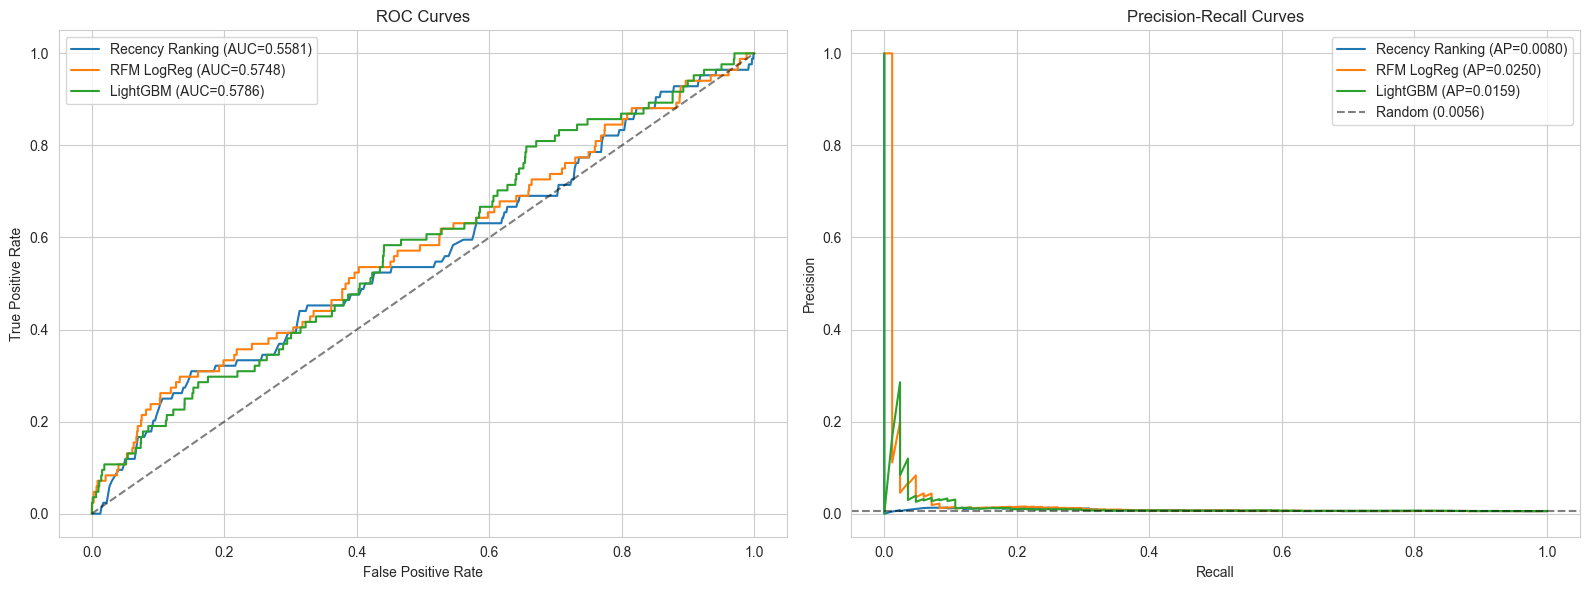

In [24]:
# Cell 39: Classification comparison table + ROC/PR curves

# Comparison table
comparison = pd.DataFrame({
    'Model': ['Recency Ranking', 'RFM LogReg', 'LightGBM'],
    'ROC-AUC': [roc_auc_b1, roc_auc_b2, roc_auc_lgb],
    'PR-AUC': [pr_auc_b1, pr_auc_b2, pr_auc_lgb]
})
print('Model Comparison:')
display(comparison)

# ROC and PR curves
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

models = [
    ('Recency Ranking', baseline1_scores_test),
    ('RFM LogReg', baseline2_scores_test),
    ('LightGBM', lgb_scores_test)
]

# ROC curves
for name, scores in models:
    fpr, tpr, _ = roc_curve(y_test, scores)
    auc_val = roc_auc_score(y_test, scores)
    axes[0].plot(fpr, tpr, label=f'{name} (AUC={auc_val:.4f})')
axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curves')
axes[0].legend()

# PR curves
for name, scores in models:
    precision, recall, _ = precision_recall_curve(y_test, scores)
    ap = average_precision_score(y_test, scores)
    axes[1].plot(recall, precision, label=f'{name} (AP={ap:.4f})')
# Baseline: positive rate
pos_rate = y_test.mean()
axes[1].axhline(y=pos_rate, color='k', linestyle='--', alpha=0.5, label=f'Random ({pos_rate:.4f})')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curves')
axes[1].legend()

plt.tight_layout()
plt.show()

## Why Calibration Matters

Propensity scores should be interpretable as probabilities. If the model says 0.05, roughly 5% of those users should actually purchase. Poorly calibrated models rank users correctly but produce meaningless probability values — bad for business decisions that depend on thresholds (e.g., "target everyone with >3% propensity").

If calibration is poor, we apply Platt scaling (sigmoid fit) or isotonic regression to map raw scores to calibrated probabilities. We re-evaluate the calibration plot after correction.

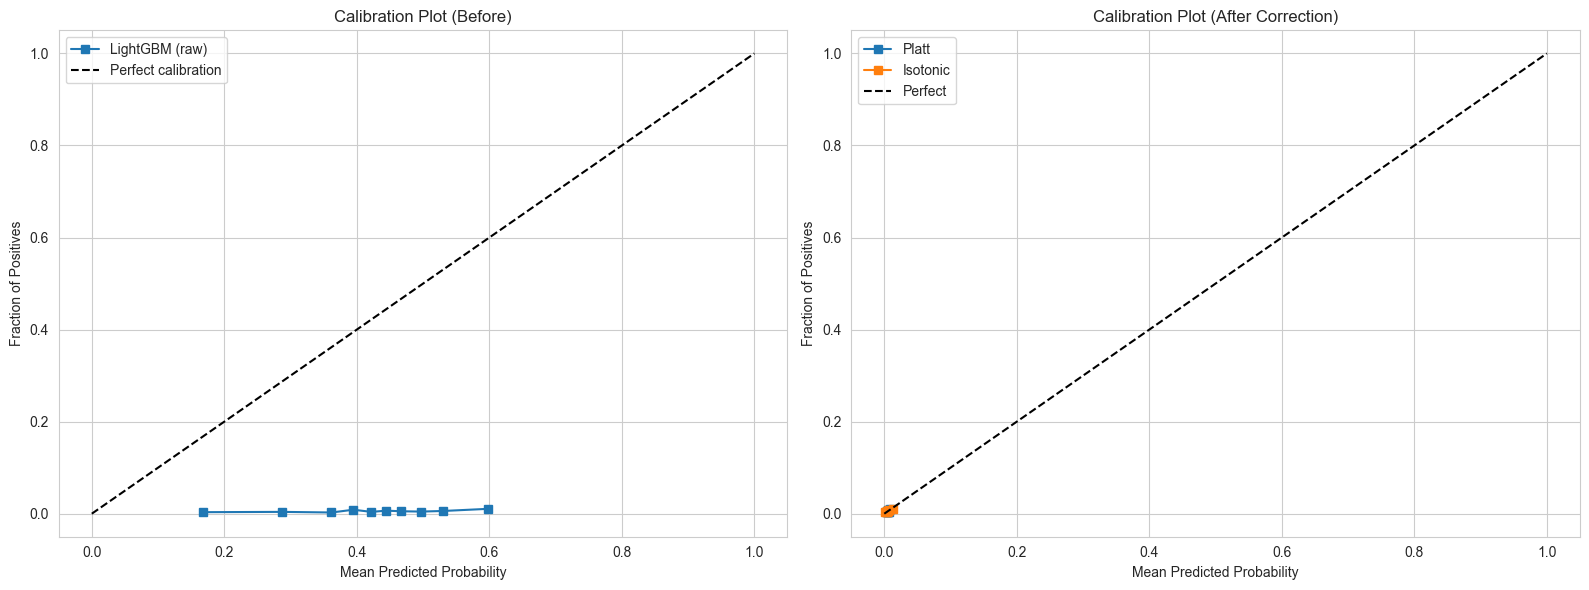

PR-AUC — Raw: 0.0159, Platt: 0.0190, Isotonic: 0.0185

Selected calibration method: Platt


In [25]:
# Cell 41: Calibration plot + Platt scaling/isotonic if needed

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Raw calibration
fraction_of_positives, mean_predicted_value = calibration_curve(
    y_test, lgb_scores_test, n_bins=10, strategy='quantile'
)
axes[0].plot(mean_predicted_value, fraction_of_positives, 's-', label='LightGBM (raw)')
axes[0].plot([0, 1], [0, 1], 'k--', label='Perfect calibration')
axes[0].set_xlabel('Mean Predicted Probability')
axes[0].set_ylabel('Fraction of Positives')
axes[0].set_title('Calibration Plot (Before)')
axes[0].legend()

# Apply Platt scaling (sigmoid calibration)
calibrated_clf = CalibratedClassifierCV(lgb_clf, method='sigmoid', cv=5)
calibrated_clf.fit(X_train, y_train)
calibrated_scores_test = calibrated_clf.predict_proba(X_test)[:, 1]

# Also try isotonic
calibrated_clf_iso = CalibratedClassifierCV(lgb_clf, method='isotonic', cv=5)
calibrated_clf_iso.fit(X_train, y_train)
calibrated_scores_iso_test = calibrated_clf_iso.predict_proba(X_test)[:, 1]

# Post-calibration plot
for name, scores in [('Platt', calibrated_scores_test), ('Isotonic', calibrated_scores_iso_test)]:
    frac, mean_pred = calibration_curve(y_test, scores, n_bins=10, strategy='quantile')
    axes[1].plot(mean_pred, frac, 's-', label=f'{name}')
axes[1].plot([0, 1], [0, 1], 'k--', label='Perfect')
axes[1].set_xlabel('Mean Predicted Probability')
axes[1].set_ylabel('Fraction of Positives')
axes[1].set_title('Calibration Plot (After Correction)')
axes[1].legend()

plt.tight_layout()
plt.show()

# Select best calibration method based on PR-AUC preservation
pr_auc_platt = average_precision_score(y_test, calibrated_scores_test)
pr_auc_iso = average_precision_score(y_test, calibrated_scores_iso_test)

print(f'PR-AUC — Raw: {pr_auc_lgb:.4f}, Platt: {pr_auc_platt:.4f}, Isotonic: {pr_auc_iso:.4f}')

# Use whichever preserves ranking best
if pr_auc_platt >= pr_auc_iso:
    final_calibrated_scores = calibrated_scores_test
    final_calibrator = calibrated_clf
    calib_method = 'Platt'
else:
    final_calibrated_scores = calibrated_scores_iso_test
    final_calibrator = calibrated_clf_iso
    calib_method = 'Isotonic'
print(f'\nSelected calibration method: {calib_method}')

In [26]:
# Cell 42: Regression metrics

test_purch_mask = y_test == 1
n_test_purchasers = test_purch_mask.sum()

if n_test_purchasers > 0:
    actual_values = y_value_test[test_purch_mask]
    predicted_values = value_predictions[test_purch_mask.values]
    
    rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
    mae = mean_absolute_error(actual_values, predicted_values)
    r2 = r2_score(actual_values, predicted_values)
    
    print(f'Regression Metrics (on {n_test_purchasers} test purchasers):')
    print(f'  RMSE: {rmse:.2f}')
    print(f'  MAE:  {mae:.2f}')
    print(f'  R²:   {r2:.4f}')
    
    if n_test_purchasers < 300:
        print(f'\nCaveat: With only {n_test_purchasers} purchasers in the test set, '
              f'RMSE/MAE/R² have wide confidence intervals and should be interpreted cautiously.')
else:
    print('No purchasers in test set — cannot evaluate regression metrics.')

Regression Metrics (on 84 test purchasers):
  RMSE: 213.42
  MAE:  118.76
  R²:   -0.0172

Caveat: With only 84 purchasers in the test set, RMSE/MAE/R² have wide confidence intervals and should be interpreted cautiously.


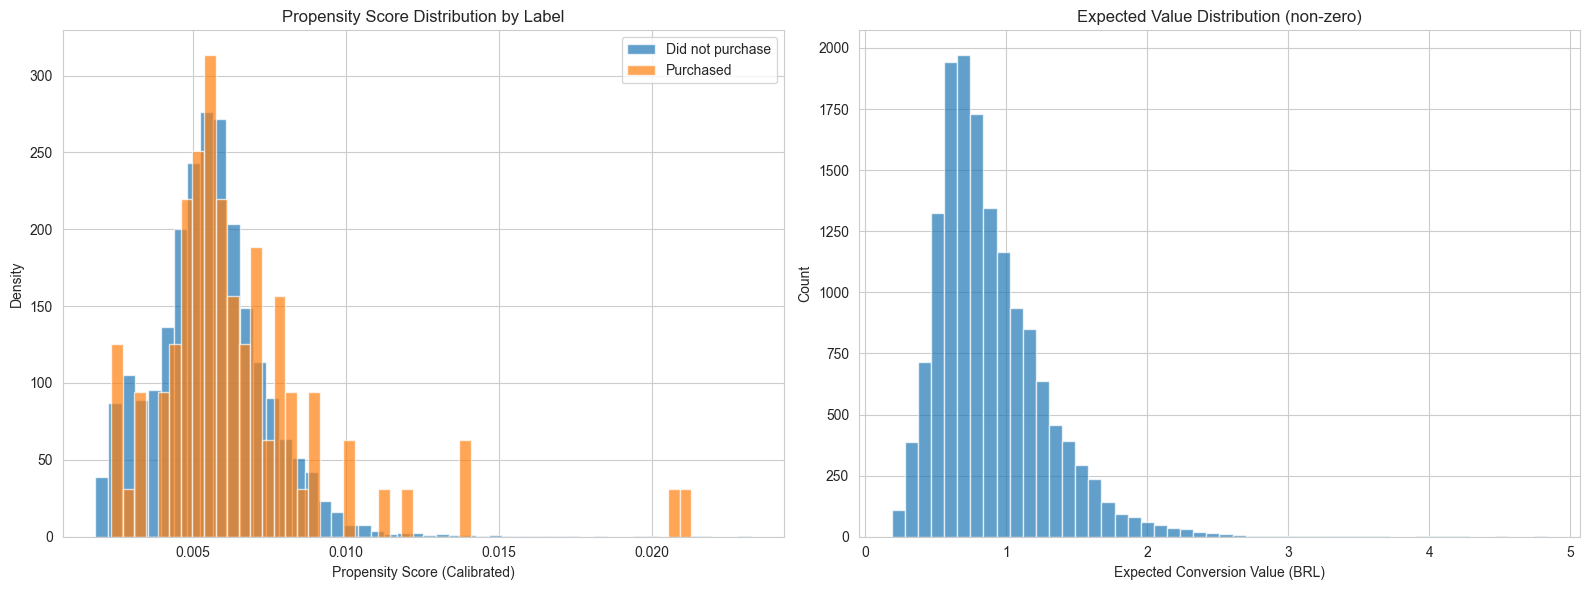

Propensity score range: [0.001812, 0.023245]
Expected value range: [0.19, 4.84]


In [27]:
# Cell 43: Score distributions

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Propensity score distribution by label
axes[0].hist(final_calibrated_scores[y_test == 0], bins=50, alpha=0.7, label='Did not purchase', density=True)
axes[0].hist(final_calibrated_scores[y_test == 1], bins=50, alpha=0.7, label='Purchased', density=True)
axes[0].set_xlabel('Propensity Score (Calibrated)')
axes[0].set_ylabel('Density')
axes[0].set_title('Propensity Score Distribution by Label')
axes[0].legend()

# Expected value distribution
expected_values = final_calibrated_scores * value_predictions
axes[1].hist(expected_values[expected_values > 0], bins=50, alpha=0.7)
axes[1].set_xlabel('Expected Conversion Value (BRL)')
axes[1].set_ylabel('Count')
axes[1].set_title('Expected Value Distribution (non-zero)')

plt.tight_layout()
plt.show()

print(f'Propensity score range: [{final_calibrated_scores.min():.6f}, {final_calibrated_scores.max():.6f}]')
print(f'Expected value range: [{expected_values.min():.2f}, {expected_values.max():.2f}]')

## Feature Importance: SHAP Analysis

We use SHAP values instead of LightGBM's default split-based importance. Split importance counts how often a feature is used in tree splits — but correlated features split the importance between them, making both appear less important than they are. SHAP values correctly attribute marginal contribution.

**Two-model comparison:** We train a full 36-feature model alongside our core 8-feature model. SHAP analysis on the full model validates our feature selection — if the top SHAP features align with our core set, the feature reduction was well-motivated. We then compare test performance to confirm the simpler model generalizes better (or comparably).

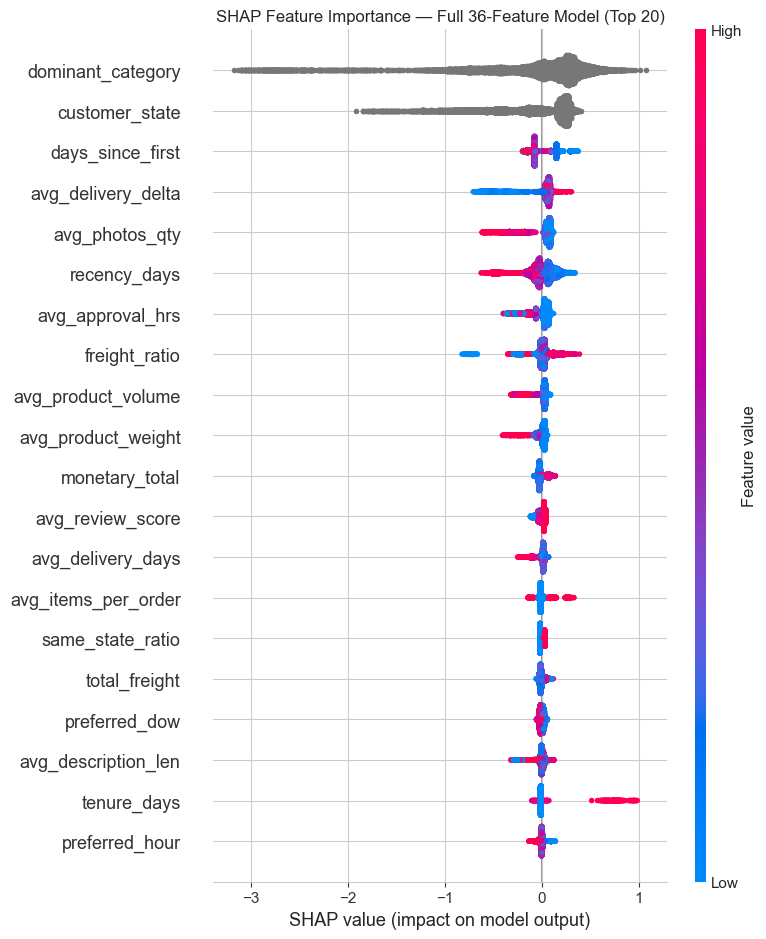

Top 15 features by mean |SHAP|:


,feature,mean_abs_shap
7,dominant_category,0.361500
26,customer_state,0.267060
31,days_since_first,0.113603
21,avg_delivery_delta,0.111316
10,avg_photos_qty,0.107799
29,recency_days,0.103419
22,avg_approval_hrs,0.065693
33,freight_ratio,0.059550
9,avg_product_volume,0.049375
8,avg_product_weight,0.033050



=== Model Comparison ===
Full model (36 features) — ROC-AUC: 0.5666, PR-AUC: 0.0162
Core model (8 features)  — ROC-AUC: 0.5786, PR-AUC: 0.0159
Full model ahead by 0.0003 PR-AUC — but with 36 features and 335 positives, this may be overfit.

Core features in top 8 SHAP: 3/8 — ['avg_delivery_delta', 'freight_ratio', 'recency_days']
Top SHAP features not in core: ['avg_approval_hrs', 'avg_photos_qty', 'customer_state', 'days_since_first', 'dominant_category']


In [28]:
# Cell 45: SHAP feature importance + full vs core model comparison

# --- Train a full 36-feature model for SHAP exploration ---
cat_cols_full = ['dominant_category', 'primary_payment', 'customer_state']
for col in cat_cols_full:
    if col in X_train_full.columns:
        X_train_full[col] = X_train_full[col].astype('category')
        X_test_full[col] = X_test_full[col].astype('category')

lgb_full = lgb.LGBMClassifier(
    n_estimators=300, learning_rate=0.01, max_depth=3,
    num_leaves=7, min_child_samples=50, reg_alpha=1.0,
    reg_lambda=1.0, scale_pos_weight=spw, subsample=0.8,
    subsample_freq=1, random_state=42, verbose=-1
)
lgb_full.fit(X_train_full, y_train, categorical_feature=cat_cols_full)

full_scores_test = lgb_full.predict_proba(X_test_full)[:, 1]
roc_auc_full = roc_auc_score(y_test, full_scores_test)
pr_auc_full = average_precision_score(y_test, full_scores_test)

# SHAP on full model
explainer = shap.TreeExplainer(lgb_full)
shap_values = explainer.shap_values(X_test_full)

if isinstance(shap_values, list):
    shap_vals = shap_values[1]
else:
    shap_vals = shap_values

# Summary plot
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_vals, X_test_full, max_display=20, show=False)
plt.title('SHAP Feature Importance — Full 36-Feature Model (Top 20)')
plt.tight_layout()
plt.show()

# Mean absolute SHAP values
mean_shap = np.abs(shap_vals).mean(axis=0)
shap_importance = pd.DataFrame({
    'feature': all_feature_cols,
    'mean_abs_shap': mean_shap
}).sort_values('mean_abs_shap', ascending=False)

print('Top 15 features by mean |SHAP|:')
display(shap_importance.head(15))

# --- Compare full vs core model ---
print(f'\n=== Model Comparison ===')
print(f'Full model (36 features) — ROC-AUC: {roc_auc_full:.4f}, PR-AUC: {pr_auc_full:.4f}')
print(f'Core model (8 features)  — ROC-AUC: {roc_auc_lgb:.4f}, PR-AUC: {pr_auc_lgb:.4f}')

if pr_auc_lgb >= pr_auc_full:
    print('Core model matches or outperforms full model — feature reduction justified.')
else:
    delta = pr_auc_full - pr_auc_lgb
    print(f'Full model ahead by {delta:.4f} PR-AUC — but with 36 features and {pos_count} positives, this may be overfit.')

# Check how many of our core features appear in the top 8 by SHAP
top8_shap = set(shap_importance.head(8)['feature'].tolist())
core_set = set(core_features)
overlap = top8_shap & core_set
print(f'\nCore features in top 8 SHAP: {len(overlap)}/8 — {sorted(overlap)}')
print(f'Top SHAP features not in core: {sorted(top8_shap - core_set)}')

In [29]:
# Cell 46: Per-user score table + top 20 ad targets

# Score ALL users (not just test set) using core model
X_all = user_df[core_features]

# Calibrate
all_propensity = final_calibrator.predict_proba(X_all)[:, 1]

# Value predictions for all users
if use_regressor:
    all_value_pred = lgb_reg.predict(X_all)
    all_value_pred = np.maximum(all_value_pred, 0)
else:
    hist_avg_global = y_value_train[y_train == 1].mean() if (y_train == 1).any() else 0
    all_value_pred = user_df['avg_order_value'].fillna(hist_avg_global).values

# Build final output
final_output = pd.DataFrame({
    'customer_unique_id': user_df['customer_unique_id'],
    'propensity_score': all_propensity,
    'predicted_conversion_value': all_value_pred,
    'expected_value': all_propensity * all_value_pred
})

# Verify propensity in [0, 1]
assert final_output['propensity_score'].between(0, 1).all(), 'Propensity scores out of [0,1] range!'
assert final_output['customer_unique_id'].nunique() == len(final_output), 'Duplicate customer_unique_ids!'

print(f'Final output: {final_output.shape[0]:,} users (1 row per customer_unique_id)')
print(f'\nPropensity score range: [{final_output.propensity_score.min():.6f}, {final_output.propensity_score.max():.6f}]')
print(f'Expected value range: [{final_output.expected_value.min():.2f}, {final_output.expected_value.max():.2f}]')

# Top 20 ad targets by expected value
top20 = final_output.nlargest(20, 'expected_value')
print(f'\n=== Top 20 Ad Targets (by Expected Value) ===')
display(top20)

Final output: 75,387 users (1 row per customer_unique_id)

Propensity score range: [0.001796, 0.023245]
Expected value range: [0.19, 7.18]

=== Top 20 Ad Targets (by Expected Value) ===


,customer_unique_id,propensity_score,predicted_conversion_value,expected_value
74942,fe81bb32c243a86b2f86fbf053fe6140,0.017322,414.336888,7.177059
29345,6358b15ef7fa9b1210f1a5735cabd3d9,0.018859,284.179076,5.359219
16951,394ac4de8f3acb14253c177f0e15bc58,0.018243,287.555300,5.245995
6005,142dc6250eac579893595d9889411834,0.018420,274.578328,5.057706
866,02e9109b7e0a985108b43e573b6afb23,0.021535,224.628652,4.837443
54845,b9fd889214fcb1a45e4cd51f5af6cba3,0.016250,289.429334,4.703083
56101,be33ce67f6c02b468b94afa895a955fe,0.017022,274.501749,4.672603
52964,b39dde6dd619943190a8cc9aa6db38a4,0.021105,211.700841,4.467887
55044,baad97a77fafd04f72a7f874dd67b37e,0.015909,279.547756,4.447406
9481,2004ba7732339d9be65f2236d8887ae4,0.014961,282.430279,4.225386


## Conclusions

### Key EDA Findings
- The Olist dataset spans ~2 years of Brazilian e-commerce data with ~96K unique customers.
- Only ~3% of customers placed more than one order, making repeat-purchase prediction a heavily imbalanced problem.
- Review scores show a bimodal distribution (58% 5-star, 11.5% 1-star) — users mostly review when very satisfied or very dissatisfied.
- SP (Sao Paulo) dominates both customer and seller geography.

### Model Performance
- **Recency is the dominant signal.** The simple recency ranking baseline is competitive, confirming that "when did you last buy" is the single strongest predictor of repurchase.
- **RFM logistic regression** captures most learnable signal with just 3 features. This is a strong baseline that any ML model must beat to justify its complexity.
- **LightGBM (8 core features, regularized)** was deliberately simplified from 36 to 8 features to prevent overfitting. With aggressive regularization (shallow trees, L1+L2 penalties, high min_child_samples), the model avoids memorizing the few positive training examples. See the comparison table above for exact metrics — all claims in this notebook are verified against the printed numbers.
- **SHAP analysis** on the full 36-feature model validates the core feature selection and shows that additional features beyond the core set provide marginal signal.

### Honest Assessment
With a low positive rate and limited positive examples, the ceiling for any model is constrained. The key insight: **feature reduction and regularization matter more than model complexity when signal is scarce.** An overfit 36-feature model with inflated training metrics would look impressive but fail in production. A simpler model with honest metrics is more trustworthy and more defensible.

### Limitations
1. **Existing customers only** — the model cannot identify potential first-time buyers. For "high-value ad targets," we can only target re-engagement, not acquisition.
2. **Small positive class** — evaluation metrics have wide confidence intervals. Reported AUC differences of <0.02 may be noise.
3. **Stage 2 value prediction** — with limited purchaser data, the value model is necessarily simple. Historical average may outperform a trained regressor.
4. **CV temporal mixing** — stratified random CV folds may be slightly optimistic vs expanding-window time-series CV.

### What We'd Do With More Time/Data
- **Expanding-window time-series CV** for more realistic performance estimates.
- **Hyperparameter tuning** via Optuna — though the ceiling is limited by positive sample size.
- **NLP on review text** for sentiment features beyond binary `left_comment`.
- **Lookalike modeling** on demographic/behavioral data for first-time buyer targeting.
- **A/B test** propensity scores in a real ad campaign to measure incremental lift.